In [2]:
import pandas as pd
import numpy as np

# Load data

In [3]:
# Load the uploaded CSV files
adcfdna_df = pd.read_csv('../../../data/adcfdna_2024.csv')
ademb_df = pd.read_csv('../../../data/ademb_2024.csv')
lvef = pd.read_csv("../../../data/adecho_2024.csv")
egfr = pd.read_csv("../../../data/adlb_2024.csv")
dsa = pd.read_csv("../../../data/addsa_2024.csv")

/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_62604/3336791843.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  adcfdna_df = pd.read_csv('../../../data/adcfdna_2024.csv')
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_62604/3336791843.py:5: DtypeWarning: Columns (18,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  egfr = pd.read_csv("../../../data/adlb_2024.csv")


In [4]:
adcfdna_df.loc[adcfdna_df["avalc"].str.contains("<"), "aval_correct"] = adcfdna_df["avalrpt"]
adcfdna_df.loc[adcfdna_df["avalc"].str.contains(">"), "aval_correct"] = adcfdna_df["avalrpt"]
adcfdna_df.loc[adcfdna_df["aval_correct"] != adcfdna_df["aval_correct"], "aval_correct"] = adcfdna_df["aval"]
adcfdna_df["aval_correct"] = adcfdna_df["aval_correct"].astype('float')
adcfdna_df.loc[adcfdna_df["aval_correct"] < 0.11, "aval_correct"] = 0.11

# dsa

In [5]:
dsa = dsa[["usubjid", "param", "avisitn","avalc"]].dropna().drop_duplicates()
dsa = dsa.loc[dsa["param"] == "DSA Event (Yes/No)"]
dsa.drop(columns = "param", inplace = True)

# eGFR

In [6]:
eGFR = egfr[["usubjid", "ady", "param", "avisitn","aval"]].dropna().drop_duplicates()
eGFR = eGFR.loc[eGFR["param"] == "EGFR (CKD-EPI)"]

# lvef

In [7]:
filtered_lvef_df = lvef[["usubjid","ady","avisitn","aval", "crit1fl", "crit2fl", "crit3fl"]].dropna().drop_duplicates()

# Allosure and Allomap

In [8]:
# Pivot the dataframe to create a wide table for each ID and each ady
adcfdna_wide_df = adcfdna_df.pivot_table(
    index=['usubjid', 'ady', "avisitn"],
    columns='testname',
    values=['aval', 'avalc', 'aval_correct'],
    aggfunc='first'
)

# Flatten the MultiIndex columns
adcfdna_wide_df.columns = ['_'.join(col).strip() for col in adcfdna_wide_df.columns.values]
adcfdna_wide_df.reset_index(inplace=True)

# 

# BX dataset

In [9]:
# filtered_ademb_df = ademb_df[["studyid", "usubjid", "transpdt", "enbxdt", "ady","acr_yn","amr_yn", "rejection_diagnosis"]].dropna().drop_duplicates()

filtered_ademb_df = ademb_df[["studyid", "usubjid", "transpdt", "enbxdt", "ady","rejection_diagnosis", "acr_yn", "amr_yn"]].dropna().drop_duplicates()

In [10]:
filtered_ademb_df.value_counts("rejection_diagnosis")

rejection_diagnosis
No     25969
Yes     1466
Name: count, dtype: int64

In [11]:
ademb_df.acr_yn.value_counts()

acr_yn
No     26780
Yes      775
Name: count, dtype: int64

### difference between Allosure dataset and Bx dataset

In [12]:
len(set(filtered_ademb_df.usubjid) - set(adcfdna_wide_df.usubjid))

75

# Excluding acr != amr cases (optional)

In [13]:
# filtered_ademb_df = filtered_ademb_df.loc[filtered_ademb_df["acr_yn"] == filtered_ademb_df["amr_yn"]]

In [14]:
# filtered_ademb_df.value_counts("rejection_diagnosis")

# Merge allosure and bx dataset

In [15]:
# Merge the ademb dataframe onto the new wide table
final_merged_df = adcfdna_wide_df.merge(filtered_ademb_df, on='usubjid', how='left', suffixes=('_dna', '_rej'))


# Calculate the difference between ady_rej and ady_dna
final_merged_df['ady_diff'] = (final_merged_df['ady_rej'] - final_merged_df['ady_dna'])

'''POST ALLOSURE
'''
# final_merged_df.loc[final_merged_df['ady_diff'] < 0, 'ady_diff'] = 9999
'''
'''

final_merged_df['ady_diff'] = final_merged_df['ady_diff'].abs()


final_merged_df.sort_values(["usubjid", "ady_dna", "ady_diff"], ascending=[True, True, True], inplace=True)
final_merged_df.drop_duplicates(subset=["usubjid", "ady_dna"], keep='first', inplace=True)

In [72]:
# # Merge the ademb dataframe onto the new wide table
# final_merged_df = adcfdna_wide_df.merge(filtered_ademb_df, on='usubjid', how='left', suffixes=('_dna', '_rej'))

# # Calculate the difference between ady_rej and ady_dna
# final_merged_df['ady_diff'] = (final_merged_df['ady_rej'] - final_merged_df['ady_dna']).abs()

# # Function to label the row with ady_diff closest to 0 for each usubjid and ady_dna
# def label_closest_to_zero(group):
#     closest_idx = group['ady_diff'].abs().idxmin()
#     group['closest_to_zero'] = np.where(group.index == closest_idx, 1, 0)
#     return group

# # Apply the function to the dataframe grouped by usubjid and ady_dna
# final_merged_df = final_merged_df.groupby(['usubjid', 'ady_dna']).apply(label_closest_to_zero)

### Pair diagnosis with allosure and allomap measurements

In [16]:

final_merged_df.loc[final_merged_df["ady_diff"] <= 45, "label"] = final_merged_df["rejection_diagnosis"]
final_merged_df.loc[final_merged_df["ady_diff"] > 45, "label"] = None

In [17]:
final_merged_df["label"].replace("Yes", 1, inplace = True)
final_merged_df["label"].replace("No", 0, inplace = True)

/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_62604/23515412.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_merged_df["label"].replace("Yes", 1, inplace = True)
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_62604/23515412.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [19]:
final_merged_df["label"].value_counts()

label
0.0    17039
1.0      839
Name: count, dtype: int64

# merge lvef with others

In [20]:
# Merge the ademb dataframe onto the new wide table
filtered_lvef_df.rename(columns = {"ady":"ady_lvef", "aval":"aval_lvef"}, inplace = True)
final_merged_df = final_merged_df.merge(filtered_lvef_df, on=['usubjid',"avisitn"], how='left')


In [21]:
# Calculate the difference between ady_rej and ady_dna
final_merged_df['ady_lvef_diff'] = (final_merged_df['ady_lvef'] - final_merged_df['ady_dna']).abs()

final_merged_df.sort_values(["usubjid", "ady_dna", "ady_lvef_diff"], ascending=[True, True, True], inplace=True)
final_merged_df.drop_duplicates(subset=["usubjid", "ady_dna"], keep='first', inplace=True)

In [22]:
final_merged_df["label"].value_counts()

label
0.0    17039
1.0      839
Name: count, dtype: int64

# merge eGFR with others

In [23]:
# Merge the ademb dataframe onto the new wide table
eGFR.rename(columns = {"ady":"ady_egfr", "aval":"aval_egfr"}, inplace = True)
final_merged_df = final_merged_df.merge(eGFR, on=['usubjid',"avisitn"], how='left')

# Calculate the difference between ady_rej and ady_dna
final_merged_df['ady_egfr_diff'] = (final_merged_df['ady_egfr'] - final_merged_df['ady_dna']).abs()

final_merged_df.sort_values(["usubjid", "ady_dna", "ady_egfr_diff"], ascending=[True, True, True], inplace=True)
final_merged_df.drop_duplicates(subset=["usubjid", "ady_dna"], keep='first', inplace=True)


# merge DSA with others

In [24]:
dsa.rename(columns = {"avalc":"aval_dsa"}, inplace = True)
final_merged_df = final_merged_df.merge(dsa, on = ["usubjid", "avisitn"], how = "left")
final_merged_df.drop_duplicates(subset=["usubjid", "ady_dna"], keep='first', inplace=True)

## Output mega dataset

In [25]:
final_merged_df.to_csv('../Outputs/final_merged_df_2024_45days_+-_mergedon_avistin.csv', index=False)

# Preparation of Training Cohort-ACR/AMR

In [26]:
final_merged_df.loc[final_merged_df["ady_diff"] <= 45, "label"] = final_merged_df["acr_yn"]
final_merged_df.loc[final_merged_df["ady_diff"] > 45, "label"] = None
final_merged_df["label"].replace("Yes", 1, inplace = True)
final_merged_df["label"].replace("No", 0, inplace = True)

/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_62604/2011786309.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['No' 'No' 'No' ... 'No' 'No' 'No']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_merged_df.loc[final_merged_df["ady_diff"] <= 45, "label"] = final_merged_df["acr_yn"]
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_62604/2011786309.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace o

In [27]:
final_merged_df["label"].value_counts()

label
0.0    17531
1.0      347
Name: count, dtype: int64

In [28]:
train_df = final_merged_df[["usubjid", "ady_dna", "ady_diff", "avisitn", "aval_AlloMap", "aval_AlloSure", "aval_correct_AlloSure", "aval_lvef","ady_lvef_diff","aval_egfr", "ady_egfr_diff", "label", "acr_yn","amr_yn", "rejection_diagnosis", 'crit1fl', 'crit2fl', 'crit3fl', "aval_dsa"]]

# train_df = final_merged_df[["usubjid", "ady_dna", "ady_diff", "avisitn", "aval_AlloMap", "aval_AlloSure", "aval_correct_AlloSure", "label", "acr_yn","amr_yn", "rejection_diagnosis",]]

In [29]:
train_df.dropna().value_counts("label")

label
0.0    5943
1.0     176
Name: count, dtype: int64

In [30]:
train_df = train_df.dropna(subset=['aval_AlloMap', 'aval_correct_AlloSure'])

### patient #, average visits per patient

In [31]:
# Calculate the number of unique IDs
unique_ids = train_df['usubjid'].nunique()

# Calculate the average number of records per ID
average_records_per_id = train_df['usubjid'].value_counts().mean()

unique_ids, average_records_per_id

(2341, np.float64(12.463049978641607))

### distribution of visits

<Axes: >

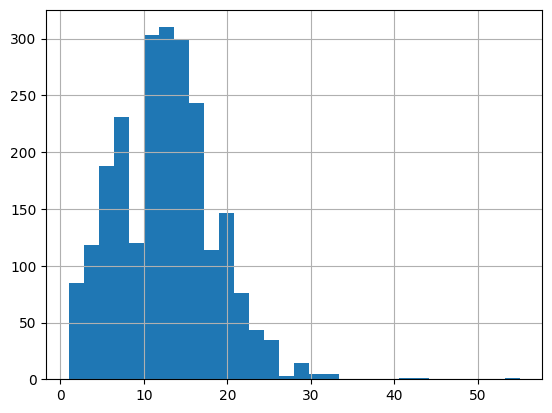

In [32]:
train_df['usubjid'].value_counts().hist(bins=30)

### rej counts and no_rej counts

In [33]:
train_df['label'].value_counts()

label
0.0    12615
1.0      279
Name: count, dtype: int64

### save as train dataset

In [92]:
# train_df = train_df.loc[train_df["ady_lvef_diff"] <= 200]
# train_df['label'].value_counts()

In [93]:
train_df.to_csv('../Outputs/train_2024_45days_+-_merged.csv', index=False)

# Create label based on lvef while eGFR diff <= 20

In [109]:
# train_df = train_df.loc[train_df["ady_egfr_diff"] <= 45]
# train_df['label'].value_counts()

In [110]:
train_df.to_csv('../Outputs/train_2024_45days_+-_egfr_mergedon_avistin.csv', index=False)

# Create label based on lvef

In [47]:
final_merged_df.loc[final_merged_df["ady_lvef_diff"] <= 45, "label"] = final_merged_df["crit3fl"]
final_merged_df.loc[final_merged_df["ady_lvef_diff"] > 45, "label"] = None
final_merged_df["label"].replace("Y", 1, inplace = True)
final_merged_df["label"].replace("N", 0, inplace = True)

train_df = final_merged_df[["usubjid", "ady_dna", "avisitn", "aval_AlloMap", "aval_AlloSure", "aval_correct_AlloSure", "aval_lvef","ady_lvef_diff","label", "acr_yn","amr_yn", "rejection_diagnosis", 'crit1fl', 'crit2fl', 'crit3fl']]
train_df = train_df.dropna(subset=['aval_AlloMap', 'aval_correct_AlloSure'])
train_df.to_csv('../Outputs/train_2024_45days_+-_lvef_level3.csv', index=False)

/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_69131/2778858737.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Y' 'Y' 'Y' ... 'N' 'N' 'N']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_merged_df.loc[final_merged_df["ady_lvef_diff"] <= 45, "label"] = final_merged_df["crit3fl"]
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_69131/2778858737.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace o

# Visualization of trends

### stats summary and smooth the data|

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = train_df.copy()

# Step 1: Statistical Summary of ady_dna
ady_dna_summary = data[['usubjid', 'ady_dna', "avisitn", "aval_AlloSure", "aval_AlloMap", "aval_correct_AlloSure"]].describe()
print("Statistical Summary of ady_dna:")
print(ady_dna_summary)

ady_dna_summary.to_csv("../Outputs/stats_summary_2024_45days.csv")

# Label subjects based on whether they ever had a rejection
corrected_label = data.groupby('usubjid')['label'].apply(lambda x: 1 if x.max() == 1 else 0)
data = data.merge(corrected_label.rename('label_usubjid'), on = "usubjid", how = "left")

# a function for Min-Max normalization or z-transformation etc
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

def z_transformation(series):
    return (series - series.mean()) / series.std()

# Apply Min-Max normalization to AlloSure, AlloMap, and globally normalize ady_dna
data['norm_AlloSure'] = data.groupby('usubjid')['aval_AlloSure'].transform(min_max_normalize)
data['norm_AlloMap'] = data.groupby('usubjid')['aval_AlloMap'].transform(min_max_normalize)
# optional
data['global_norm_ady_dna'] = min_max_normalize(data['ady_dna'])

# Step 3: Bin the globally normalized 'ady_dna' into intervals or bin according to the visits
bins = 100  # Change this value as needed (e.g., bins = 10)
data['binned_global_norm_ady_dna'] = pd.cut(data['global_norm_ady_dna'], bins=bins, labels=False)


# Calculate the mean for each bin using the globally normalized 'ady_dna' or preselected avisitn
binned_data_global = data.groupby(['avisitn', 'label_usubjid']).agg({
    'norm_AlloSure': 'mean',
    'norm_AlloMap': 'mean'
}).reset_index()

# Step 4: Define a function for rolling average smoothing
def smooth_series(series, window=3):
    return series.rolling(window=window, min_periods=1).mean()

# Apply smoothing to the binned data with global normalization
binned_data_global['smooth_binned_AlloSure'] = binned_data_global.groupby('label_usubjid')['norm_AlloSure'].transform(smooth_series)
binned_data_global['smooth_binned_AlloMap'] = binned_data_global.groupby('label_usubjid')['norm_AlloMap'].transform(smooth_series)

Statistical Summary of ady_dna:
            ady_dna       avisitn  aval_AlloSure  aval_AlloMap  \
count  27201.000000  27201.000000   27201.000000  27201.000000   
mean     484.964082    494.120290       0.198058     30.280688   
std      395.256432    503.847633       0.709504      5.583049   
min       16.000000     30.000000      -0.068665      2.000000   
25%      185.000000    182.000000       0.026043     27.000000   
50%      346.000000    365.000000       0.054292     31.000000   
75%      692.000000    730.000000       0.114875     34.000000   
max     4713.000000   9999.000000      21.925017     39.000000   

       aval_correct_AlloSure  
count           27201.000000  
mean                0.249460  
std                 0.690129  
min                 0.110000  
25%                 0.110000  
50%                 0.110000  
75%                 0.140000  
max                20.287516  


## exclude some extreme cases

In [143]:
binned_data_global = binned_data_global.loc[binned_data_global["avisitn"] != 9999]
data = data.loc[data["avisitn"] != 9999]

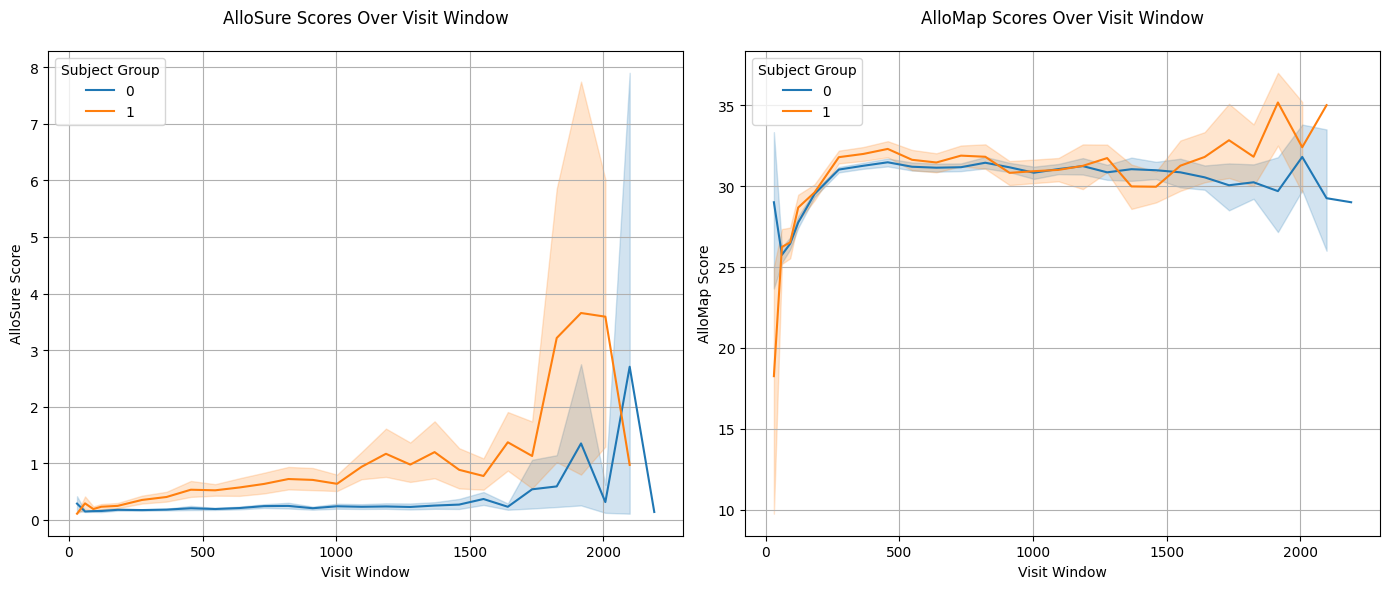

In [144]:
plt.figure(figsize=(14, 6))

# Smoothed plot for globally binned normalized AlloSure over time for the two groups
plt.subplot(1, 2, 1)
sns.lineplot(x='avisitn', y='aval_correct_AlloSure', hue='label_usubjid', data=data)
plt.title('AlloSure Scores Over Visit Window', pad=20)
plt.xlabel('Visit Window')
plt.ylabel('AlloSure Score')
plt.legend(title='Subject Group')
plt.grid(True)

# Smoothed plot for globally binned normalized AlloMap over time for the two groups
plt.subplot(1, 2, 2)
sns.lineplot(x='avisitn', y='aval_AlloMap', hue='label_usubjid', data=data)
plt.title('AlloMap Scores Over Visit Window', pad=20)
plt.xlabel('Visit Window')
plt.ylabel('AlloMap Score')
plt.legend(title='Subject Group')
plt.grid(True)

plt.tight_layout()
plt.show()

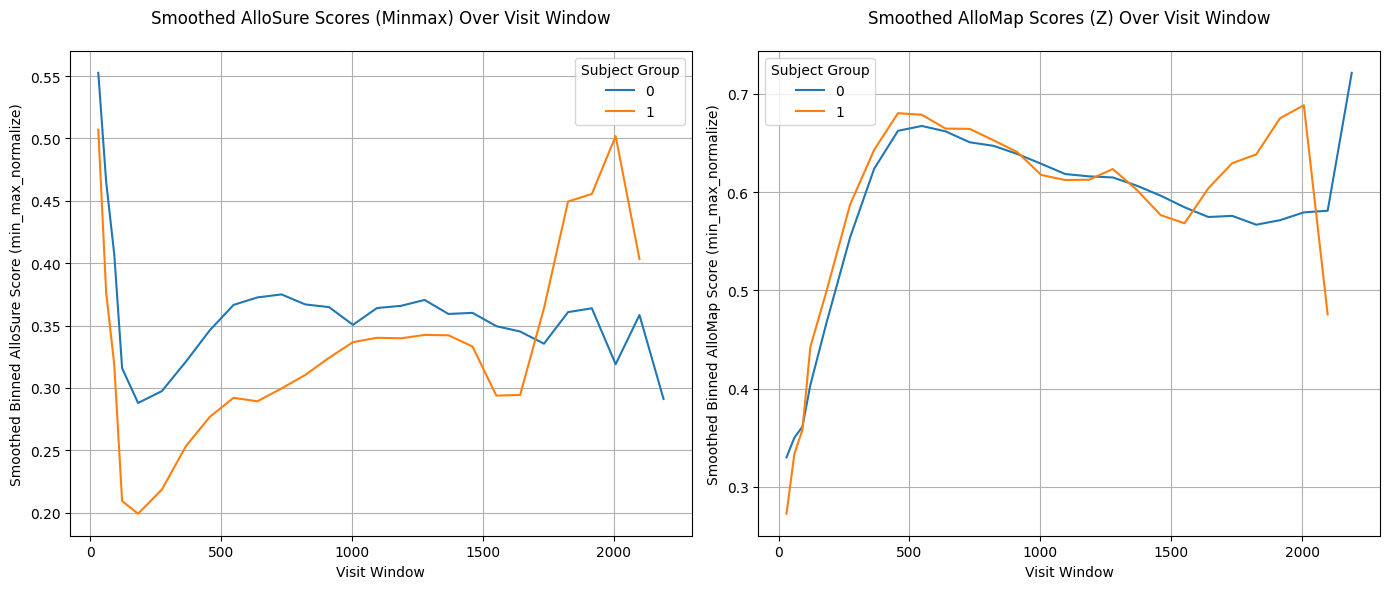

In [145]:
# Step 5: Plotting the smoothed binned normalized AlloSure and AlloMap scores over globally normalized time
plt.figure(figsize=(14, 6))

# Smoothed plot for globally binned normalized AlloSure over time for the two groups
plt.subplot(1, 2, 1)
sns.lineplot(x='avisitn', y='smooth_binned_AlloSure', hue='label_usubjid', data=binned_data_global)
plt.title('Smoothed AlloSure Scores (Minmax) Over Visit Window', pad=20)
plt.xlabel('Visit Window')
plt.ylabel('Smoothed Binned AlloSure Score (min_max_normalize)')
plt.legend(title='Subject Group')
plt.grid(True)

# Smoothed plot for globally binned normalized AlloMap over time for the two groups
plt.subplot(1, 2, 2)
sns.lineplot(x='avisitn', y='smooth_binned_AlloMap', hue='label_usubjid', data=binned_data_global)
plt.title('Smoothed AlloMap Scores (Z) Over Visit Window', pad=20)
plt.xlabel('Visit Window')
plt.ylabel('Smoothed Binned AlloMap Score (min_max_normalize)')
plt.legend(title='Subject Group')
plt.grid(True)

plt.tight_layout()
plt.show()

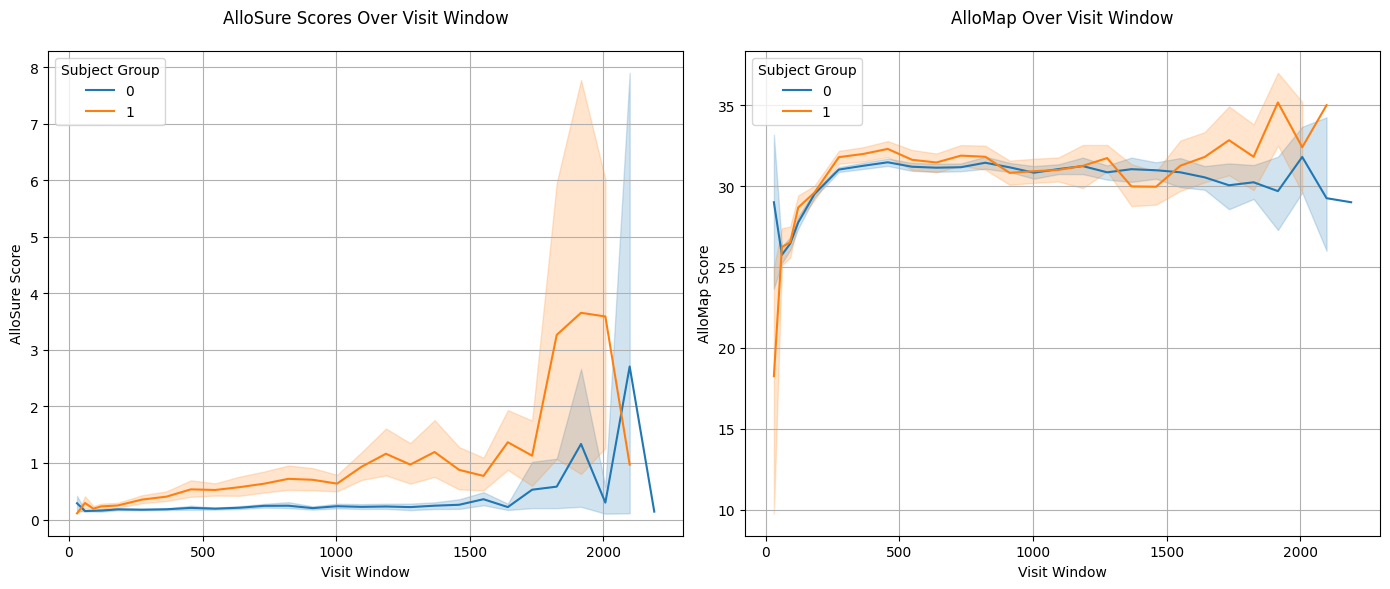

In [64]:
plt.figure(figsize=(14, 6))

# Smoothed plot for globally binned normalized AlloSure over time for the two groups
plt.subplot(1, 2, 1)
sns.lineplot(x='avisitn', y='aval_correct_AlloSure', hue='label_usubjid', data=data)
plt.title('AlloSure Scores Over Visit Window', pad=20)
plt.xlabel('Visit Window')
plt.ylabel('AlloSure Score')
plt.legend(title='Subject Group')
plt.grid(True)

# Smoothed plot for globally binned normalized AlloMap over time for the two groups
plt.subplot(1, 2, 2)
sns.lineplot(x='avisitn', y='aval_AlloMap', hue='label_usubjid', data=data)
plt.title('AlloMap Over Visit Window', pad=20)
plt.xlabel('Visit Window')
plt.ylabel('AlloMap Score')
plt.legend(title='Subject Group')
plt.grid(True)

plt.tight_layout()
plt.show()

# Exploration of 2024

In [35]:
data_cleaned = pd.read_csv("/Users/jzeng63/Desktop/CDNA/ML/HMM/TS/workplace/Data_processing/Outputs/train_2024_15days.csv")

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Parameters for sequence length handling
MAX_SEQ_LENGTH = 100  # Set a maximum sequence length
MIN_SEQ_LENGTH = 2 # Optional: Set a minimum sequence length

data_cleaned = pd.read_csv("/Users/jzeng63/Desktop/CDNA/ML/HMM/TS/workplace/Data_processing/Outputs/train_2024_45days.csv")
# Step 1: Create Previous and Current Feature Columns
def create_lag_features(df):
    # df['prev_ady_dna'] = df['ady_dna'].shift(1)
    # df['prev_avisitn'] = df['avisitn'].shift(1)
    df['prev_aval_AlloSure'] = df['aval_AlloSure'].shift(1)
    df['prev_aval_AlloMap'] = df['aval_AlloMap'].shift(1)
    df["prev_label"] = df["label"].shift(1)
    df["prev_prev_label"] = df["label"].shift(2)
    # df['prev_aval_lvef'] = df['aval_lvef'].shift(1)
    # df = df.dropna().reset_index(drop=True)  # Drop rows with NaN values
    return df

# Apply lag feature creation
data_cleaned = data_cleaned.groupby('usubjid', group_keys=False).apply(create_lag_features)

# Step 2: Truncate sequences to the maximum length
truncated_sequences = []
truncated_labels = []

for usubjid, group in data_cleaned.groupby('usubjid'):
    # Truncate based on MAX_SEQ_LENGTH
    if len(group) > MAX_SEQ_LENGTH:
        group = group.iloc[:MAX_SEQ_LENGTH]
    
    # Only include sequences longer than MIN_SEQ_LENGTH
    if len(group) >= MIN_SEQ_LENGTH:
        truncated_sequences.append(group)

# Combine truncated sequences into a DataFrame
data_truncated = pd.concat(truncated_sequences).reset_index(drop=True)

# Step 3: Normalize the features per subject
features_to_normalize = ['aval_AlloMap','aval_AlloSure', 'prev_aval_AlloSure', 'prev_aval_AlloMap']

def normalize_per_subject(df, method='minmax'):
    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'zscore':
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid method. Choose 'minmax' or 'zscore'.")
    
    df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
    return df

# Apply normalization per subject
data_normalized = data_truncated.groupby('avisitn', group_keys=False).apply(normalize_per_subject, method='zscore')

# Step 4: Convert the sequences and labels to PyTorch tensors
sequence_features = ['aval_AlloMap', 'aval_AlloSure','prev_aval_AlloSure', 'prev_aval_AlloMap', "prev_label"]
sequences = []
labels = []

for usubjid, group in data_normalized.groupby('usubjid'):
    group_data = group[sequence_features].values
    group_labels = group['label'].values
    
    sequences.append(torch.tensor(group_data, dtype=torch.float32))
    labels.append(torch.tensor(group_labels, dtype=torch.float32))


/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_83787/983335527.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_cleaned = data_cleaned.groupby('usubjid', group_keys=False).apply(create_lag_features)
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_83787/983335527.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_normalized = data_truncated.groupby('avisitn', group_keys